# Project 1: Data Analysis project
by Oekonometrioen - btq674 & vsj859

In this project, we have analysed data from the British newspaper *The Guardian* and from the *Johns Hopkins University*. After collecting data from The Guardian API we apply data cleaning and data structuring models to present the data in two graphs. The first graph shows the amount of mentions pr. day of the countries with the most confirmed cases of COVID-19. The second graph depicts the accumulated confirmed cases in the same countries.

This data could be used for an analysis of media focus. However, such an analysis is beyond the scope of this paper.

In the following section we download the packages used in our project

In [1]:
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import scraping_class
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import nltk
import matplotlib.dates as mdates
from matplotlib.transforms import Transform
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, LinearLocator)
import matplotlib.cbook as cbook
from time import sleep

%matplotlib inline

# Downloading coronavirus mentions from The Guardian
Below is a summary of what we have done in this section:
- We find all content containing the word "coronavirus" in The Guardian using their API.
- We clean this content so that we only have articles left - leaving videos, cartoons etc. out.
- We parse our articles and unpack them.
- We save the date each article is published on and sort them by date.
- We *tokenize* our articles, that is we chop each article into lists of words - this allows us to look at each individual word in each individual article.
- We look for countries mentioned in each article.

In this section we have collected all articles containing the word "coronavirus" in them.

In [6]:
# Creates a function that collects links with the word "coronavirus"
def run_links_corona():
    links_corona = []
    for i in range(1,554): #555 pages
        url_data = 'https://content.guardianapis.com/search?q=coronavirus&api-key=5dffc3d9-9f65-4735-a014-c79aa9adf099&page={}&page-size=10'.format(i)
        sleep(0.5)
        r = requests.get(url_data)
        for i in r.json()["response"]["results"]:
            links_corona.append(i["webUrl"])
        # Below we remove data content that are not articles, so that we can analyse the content of the articles
        links_corona = [url for url in links_corona if 'cartoon' not in url]
        links_corona = [url for url in links_corona if '/live/' not in url]
        links_corona = [url for url in links_corona if '/ng-interactive/' not in url]
        links_corona = [url for url in links_corona if '/video/' not in url]
        links_corona = [url for url in links_corona if '/audio/' not in url]
        links_corona = list(dict.fromkeys(links_corona))
    return links_corona

# The function below run the function above multiple times and removes all duplicates.
# This is done to counteract problems occuring from a faulty search engine
def get_links_corona():
    a = []
    for i in range(7):
        b = run_links_corona()
        for i in b:
            if i not in a:
                a.append(i)
    a = list(dict.fromkeys(a))
    return a


links_corona = get_links_corona()
len(links_corona)

5265

In [7]:
# Convert to Dataframe, and save as CSV
df_links_corona = pd.DataFrame(links_corona)
df_links_corona.to_csv('links_corona.csv')

In [2]:
corona = pd.read_csv('links_corona.csv', index_col = 0)
corona_list = corona.iloc[:]['0'].tolist()

In [3]:
# This creates a dictionary, where keys are dates (2019 as a single date, each day in 2020 as a key each)
# and the values are the links for articles published on the corresponding dates
d_links={}

for j in range(1,32):
    if j < 10:
        d_links['links_jan_{}'.format(j)] = [url for url in corona_list if '/2020/jan/0' + str(j) + '/' in url]
    else:
        d_links['links_jan_{}'.format(j)] = [url for url in corona_list if '/2020/jan/' + str(j) + '/' in url]
    
    
for f in range(1,30):
    if f < 10:
        d_links['links_feb_{}'.format(f)] = [url for url in corona_list if '/2020/feb/0' + str(f) + '/' in url]
    else:
        d_links['links_feb_{}'.format(f)] = [url for url in corona_list if '/2020/feb/' + str(f) + '/' in url]

for m in range(1,32):
    if m < 10:
        d_links['links_mar_{}'.format(m)] = [url for url in corona_list if '/2020/mar/0' + str(m) + '/' in url]
    else:
        d_links['links_mar_{}'.format(m)] = [url for url in corona_list if '/2020/mar/' + str(m) + '/' in url]

for a in range(1,6):
    if a < 10:
        d_links['links_apr_{}'.format(a)] = [url for url in corona_list if '/2020/apr/0' + str(a) + '/' in url]
    else:
        d_links['links_apr_{}'.format(a)] = [url for url in corona_list if '/2020/apr/' + str(a) + '/' in url]
    

In [4]:
# Creates a new dictionary using the one above to substitute the values with the amount of links
d_links_count = {}

for i in d_links:
    d_links_count[i] = len(d_links[i])

The code below unpacks the links so that we can use the text from the articles.

In [5]:
connector = scraping_class.Connector('logfile_Data_Project.csv')

In [6]:
# Creates functions used to unpack the data
def get_article(url):
    res,call_id = connector.get(url, 'articles_all' )
    return res

# Creates a the soup objects we wish to parse
def soupobject(res):
    res_html = res.text
    res_soup = BeautifulSoup(res_html, 'html.parser')
    return res_soup

# Creates a function which parses our html files
def parse_html(res_soup):
    article_texts = []
    non_working_link = []
    p_list = res_soup.find('div',{"class":"content__article-body from-content-api js-article__body"}) # Finds the article body
    p_list = p_list.find_all('p')
    p_list = [p.text for p in p_list]
    article_text = ' '.join(p_list)
    article_texts.append(article_text)
    
    article_titles = []
    title = res_soup.find('h1',{'class':'content__headline'})
    title = title.text
    article_titles.append(title)
    
    article_dates = []
    date = res_soup.find('p',{'class':'content__dateline'}).find('time',{'itemprop':'datePublished'}) # Finds the date
    date = date.text 
    date = re.findall('([1-9.].+[1-9.])', date) # Filters date data, to just get the date
    article_dates.append(date)
    
    return article_texts, article_titles, article_dates 

# Creates a function which creates a data frame with the published date, the name of the article,
# and the text in the article.
def put_in_dataframe(article_dates, article_titles, article_texts):
    df = pd.DataFrame({'Date': article_dates, 'Title': article_titles, 'Text': article_texts}) 
    return df

In [17]:
# Unpacks the collected data
unpacked = []
for row in corona_list:
    try:
        res = get_article(row)
        res_soup = soupobject(res)
        article_texts, article_titles, article_dates = parse_html(res_soup)
        df = put_in_dataframe(article_dates, article_titles, article_texts)
        unpacked.append(df)
    except:
        continue

unpacked_articles_corona = pd.concat(unpacked)

In [3]:
# Convert to Dataframe, and save as CSV
df_articles_corona = pd.DataFrame(unpacked_articles_corona)
df_articles_corona.to_csv('articles_corona.csv')

NameError: name 'unpacked_articles_corona' is not defined

In [7]:
corona_articles = pd.read_csv('articles_corona.csv', index_col = 0)

In [8]:
len(corona_articles['Text'])

5250

Below we use a tokenizer

In [9]:
twt = nltk.tokenize.TweetTokenizer() # Initializing the tokenizer

# Tokenizing the words in the article text, so it takes a string and returns a list of words
def preprocessing(string):
    string = str(string)
    string = string.lower() # Making all the words lower case
    string = twt.tokenize(string) # Tokenizing them
    return string




In [10]:
# Applying the preprocessing function to each article in the dataframe
articles_tokenized = corona_articles['Text'].apply(preprocessing)

In [11]:
# Defining a function that counts the matches bewteen the tokenized articles and the list of countries
def count_countries(document, country):
    n = 0
    for word in document:
        if word == country:
            n += 1
    return n

With the list of countries, we have chosen the ten countries with the most confirmed positive cases of coronavirus. Because of the method used, we are not able to analyze countries with a name with a space in between. Thankfully, we noticed that the Guardian usually refers to the United States as the US and the United Kingdom as the UK, which made it possible to include those two countries.

In [12]:
countries = ['italy',	'uk',	'germany',	'spain',	'china',
             'belgium',	'us',	'iran',	'france',	'netherlands']


In [13]:
# Adding columns for the number of matches to the dataframe
for country in countries:
    corona_articles[country] = \
    articles_tokenized.apply(count_countries, country = country)


In [14]:
#converting to datetime
corona_articles['Date'] = pd.to_datetime(corona_articles['Date'].str[2:13].str.strip().str.replace(' ','/'), dayfirst = True)
corona_articles = corona_articles.sort_values(by='Date')
corona_articles = corona_articles.iloc[2:,:]

In [15]:
articles_day = corona_articles[['Date', 'italy', 'uk',	'germany',	'spain',	'china',
             'belgium',	'us',	'iran',	'france',	'netherlands']]


In [16]:
len(articles_day['Date'])

5248

Below we make sure that each day is only represented a single time, without deleting mentions:

In [17]:
i = len(articles_day['Date']) - 1
while i > 4500:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
    
print('Done')

/Users/siffpetersen/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Done


In [18]:
while i > 4000:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
    
print('Done')

Done


In [19]:
while i > 3500:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [20]:
while i > 3000:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [22]:
while i > 2500:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [23]:
while i > 2000:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [24]:
while i > 1500:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [26]:
while i > 1000:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [28]:
while i > 500:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [29]:
while i > 0:
    a = i - 1
    if articles_day.iloc[i,0] == articles_day.iloc[a,0]:
        for column in range(1,11):
            articles_day.iloc[a,column] = articles_day.iloc[i,column] + articles_day.iloc[a,column]
    i = i - 1
print('Done')

Done


In [31]:
articles_day=articles_day.drop_duplicates(subset=['Date'])

In [33]:
articles_day.to_csv('articles_day.csv')

In [ ]:
articles_day = pd.read_csv('articles_day.csv', index_col = 0)

# Presenting The Guardian findings
In this section, we have made a figure to show the amount of mentions of each country over time.

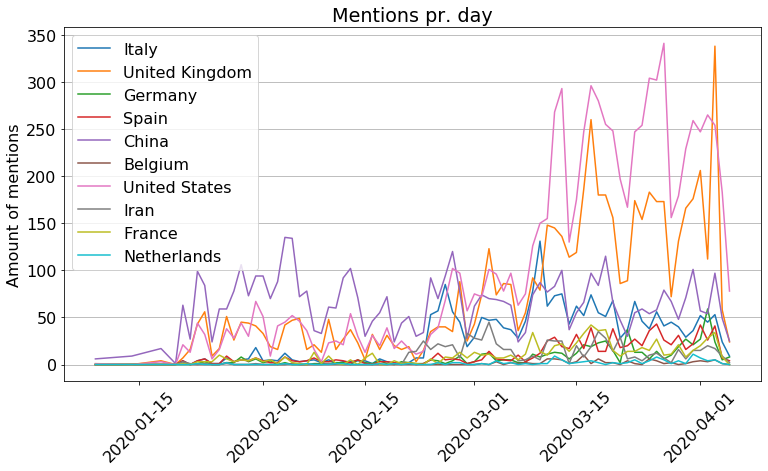

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(12.5, 6.5)

plt_italy = ax.plot(articles_day['Date'], articles_day['italy'], label='Italy')
plt_uk = ax.plot(articles_day['Date'], articles_day['uk'], label='United Kingdom')
plt_germany = ax.plot(articles_day['Date'], articles_day['germany'], label='Germany')
plt_spain = ax.plot(articles_day['Date'], articles_day['spain'], label='Spain')
plt_china = ax.plot(articles_day['Date'], articles_day['china'], label='China')
plt_belgium = ax.plot(articles_day['Date'], articles_day['belgium'], label='Belgium')
plt_us = ax.plot(articles_day['Date'], articles_day['us'], label='United States')
plt_iran = ax.plot(articles_day['Date'], articles_day['iran'], label='Iran')
plt_france = ax.plot(articles_day['Date'], articles_day['france'], label='France')
plt_netherlands = ax.plot(articles_day['Date'], articles_day['netherlands'], label='Netherlands')

    
num_years = np.arange(0, articles_day.shape[0])

ax.tick_params(axis='x', labelrotation=45)

ax.set_ylabel('Amount of mentions')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.title(label='Mentions pr. day')
plt.grid(which='major', axis='y')
plt.legend()

# Import data from excel 

In a Excel sheet we have data over the number of new daily cases of corona virus from the top 10 most affected countries in the world (as of the 04/04/2020) recorded from Johns Hopkins University of Medicin (https://coronavirus.jhu.edu/data/new-cases).

The Excel ark called 'Data.xlsx' consists of the actual data for the new daily cases of infections in the first sheet of the excel file, which we import as Data, and the accumulated cases of infections, which we import as Accu. Please note, that the following code is written under the assumption that the Excel file is located in the same location as the ipynb-file. 

In [39]:
# Open the data file.
Data = pd.read_excel('Data.xlsx', sheet_name=0, skiprows=2)
Accu = pd.read_excel('Data.xlsx', sheet_name=1, skiprows=1)
Accu.head(5)

,Date,Z,Italy,UK,Germany,Spain,China,Belgium,US,Iran,France,Netherlands
0,2020-01-24,1,0,0,0,0,277,0,0,0,0,0
1,2020-01-25,2,0,0,0,0,763,0,0,0,0,0
2,2020-01-26,3,0,0,0,0,1432,0,0,0,0,0
3,2020-01-27,4,0,0,1,0,2234,0,0,0,0,0
4,2020-01-28,5,0,0,4,0,4866,0,0,0,0,0


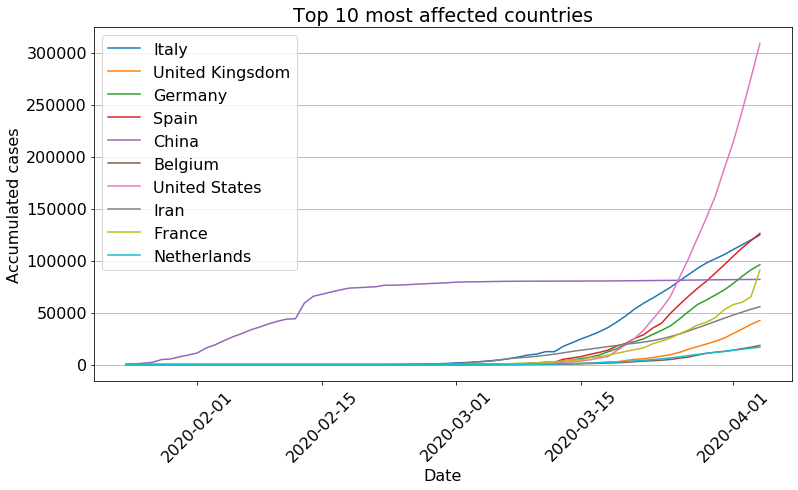

In [59]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
fig.set_size_inches(12.5, 6.5)

ax.tick_params(axis='x', labelrotation=45)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.grid(which='major', axis='y')

plt.plot(Accu['Date'], Accu['Italy'], label='Italy') 
plt.plot(Accu['Date'], Accu['UK'], label='United Kingsdom')
plt.plot(Accu['Date'], Accu['Germany'], label='Germany')  
plt.plot(Accu['Date'], Accu['Spain'], label='Spain') 
plt.plot(Accu['Date'], Accu['China'], label='China')  
plt.plot(Accu['Date'], Accu['Belgium'], label='Belgium') 
plt.plot(Accu['Date'], Accu['US'], label='United States')  
plt.plot(Accu['Date'], Accu['Iran'], label='Iran')
plt.plot(Accu['Date'], Accu['France'], label='France')
plt.plot(Accu['Date'], Accu['Netherlands'], label='Netherlands')


plt.xlabel('Date')
plt.ylabel('Accumulated cases')
plt.title("Top 10 most affected countries")


plt.legend()     